In [173]:
import mdptoolbox.example
import gym
import numpy as np
import sys
import time
import warnings
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scipy.signal as signal
import scipy
sns.set()
warnings.filterwarnings('ignore')

In [174]:
def discount(x, gamma):
    """
      Compute discounted sum of future values
      out[i] = in[i] + gamma * in[i+1] + gamma^2 * in[i+2] + ...
    """
    return signal.lfilter([1], [1, -gamma], x[::-1], axis=0)[::-1]

In [175]:
def sample_dataset(env,gamma,pi,num_episode):
    
    dataset = []
    for i in range(num_episode):
        states = []
        actions = []
        rewards = []
        state = env.env.reset()
        while True:
            states.append(state)
            action = np.random.choice(a=env.actions,p=pi[state])
            actions.append(action)
            next_state, reward, done, info = env.env.step(action)
            state = next_state
            rewards.append(reward)
            if done is True:
                break
        discounted_rewards = discount(np.array(rewards),gamma)
        episode = {'states':states,'actions':actions,'rewards':rewards,'disc_reward':discounted_rewards}
        
        dataset.append(episode)
     
    
    advantage = []
    reward = []
    for episode in dataset:
        reward.append(np.sum(np.array(episode['rewards'])))
        for i in range(len(episode['states'])):
            x = np.zeros(env.num_state*env.num_action)
            s_a = (episode['states'][i]*env.num_action)+episode['actions'][i]
            x[s_a] = episode['disc_reward'][i]
            advantage.append(x)
            
    return_1 = np.mean(np.array(advantage),axis=0)  
    
    #return_2 = 
    
    return return_1,reward
            
        
        
        
        
            
            
            
            
        
    
    
    

In [176]:
def trpo_simplex_rl(env,delta,gamma,num_iterations,num_episode):
    average = []
    M = []
    m = []
    pi = np.ones((env.num_state,env.num_action)) / env.num_action   #Policy Initialization
    
    
    
    for i in range(num_iterations):
        #V = evaluate_policy(env, pi, gamma, theta)
        #Q_value = evaluate_q(env, pi, gamma, V)
        #history.append(np.mean(V))
        
        L,reward = sample_dataset(env,gamma,pi,num_episode)
        average.append(np.mean(np.array(reward)))
        M.append(np.max(np.array(reward)))
        m.append(np.min(np.array(reward)))
  
        
        
        '''
        c
        '''
       
        L = list(L) + list(np.zeros(env.num_state*env.num_action))
        
        c = -np.array(L)
        
        '''
        A_ub
        '''
        g_1 = [np.array(list(np.zeros(env.num_state*env.num_action)) + list(np.ones(env.num_state*env.num_action)))]
        
        g_21 = np.identity(env.num_state*env.num_action)
        g_22 = -np.identity(env.num_state*env.num_action)
        
        g_2 = list(np.concatenate((g_21,g_22),axis=1))
        
        g_31 = -np.identity(env.num_state*env.num_action)
        g_32 = -np.identity(env.num_state*env.num_action)
        
        g_3 = list(np.concatenate((g_31,g_32),axis=1))
        I = -np.identity(2*env.num_state*env.num_action)
        
        A_ub = np.concatenate((np.array(g_1+g_2+g_3),I),axis=0)
        
        '''
        b_ub
        '''
        pi_1 = np.reshape(pi,(1,-1))[0]
        h = matrix(np.array([delta]+list(pi_1)+list(-pi_1)+list(np.zeros(2*env.num_state*env.num_action))))
        b_ub = np.array([delta]+list(pi_1)+list(-pi_1)+list(np.zeros(2*env.num_state*env.num_action)))
        
        
        
        
        
        '''
        b_eq
        '''
        b_eq = np.ones(env.num_state)
        
        '''
        A_eq
        '''
        A = []
        I = np.identity(env.num_state*env.num_action)
        for s in env.states:
            x = 0
            for a in range(s*env.num_action,s*env.num_action+env.num_action):
                
                x += I[a]
            
            A.append(np.array(list(x)+list(np.zeros(env.num_state*env.num_action))))
        A_eq = np.array(A)  
        
         #with HiddenPrints():
        #sol=solvers.qp(Q, p, G, h, A, b)
            
        res = scipy.optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,method='simplex')
        pi = res['x'][:env.num_state*env.num_action]
        
        pi = np.reshape(pi,(env.num_state,env.num_action))
        
    return average,M,m


In [177]:
class Agent:
    def __init__(self,environment):
        self.num_action = environment.action_space.n
        self.num_state = environment.observation_space.n
        self.states = np.array(range(0,environment.observation_space.n))
        self.actions = np.array(range(0,environment.action_space.n))
        self.env = environment
        
    

In [178]:
environment = gym.make('NChain-v0')
env = Agent(environment)
gamma = 0.9
delta = 0.9
num_iterations = 50
num_episode = 50

In [179]:
avg,M,m = trpo_simplex_rl(env,delta,gamma,num_iterations,num_episode)

In [180]:
def plot(p1,p2,p3,iterations):
    
    x=np.array(range(1,iterations+1))
    #y=total_rewards
    plt.tick_params(axis='y',labelsize=9)
    plt.tick_params(axis='x',labelsize=9)
    plt.xlabel('Iterations', fontsize=12)
    plt.plot(x,p1, label='Average Total Reward/Iteration')
    plt.plot(x,p2,label='Max Total Reward/Iteration') 
    plt.plot(x,p3,label='Min Total Reward/Iteration') 

    plt.title('NChain-v0 TRPO-Simplex',fontsize=12)
    fig_size=(10,7)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='lower right') 
    plt.show()

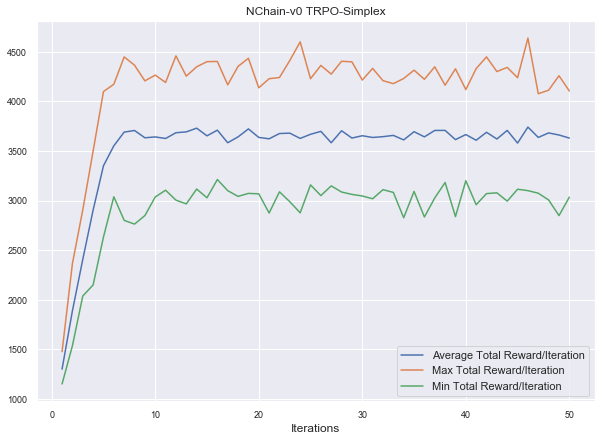

In [181]:
plot(avg,M,m,len(avg))